In [1]:
%load_ext autoreload
%autoreload 2

# Lens Calibration

The goal here is to learn the optical properties of the camera:
- Focal length
- Optical center
- Distortions

Even if your camera has built-in distortion, most lenses have focus breathing so your focal length will depend on the focus. As a result your effective focal length is very often different than the one reported by the manufacturer of the lens.

## Important!

A calibration is for a focus distance only. As mentioned above, most lenses change their focal length when making the focus closer or further. Make sure you lock your focus (and set it to manual) before calibration and for the duration of the capture. It's best to fist choose a good focus distance, lock it and then do the calibration.


## Setup

The goal is to display the calibration pattern on a good quality screen, and take multiple pictures making sure that you cover the entire surface of your sensor very well. You should change positions and viewpoints. 30 images is usually good enough.

## Camera settings

If you camera allow, to increase depth of field try to increase the aperture 

### Screen Specifications:

THe screen should be big enough such that its areay occupies a significant of the image. If it's too small the estimation of the pose of the camera will be too uncertain.

Ensure you know the following about your screen:

1. **Resolution**: 
   - The exact pixel dimensions of your screen (e.g., 1920x1080).
   
2. **Pixel Details**: 
   - You should know either:
     - **PPI (Pixels Per Inch)**: The number of pixels per inch of the screen.
     - **Pixel Size**: The dimensions of a single pixel in millimeters.
     
 
### Settings

Enter your information below (should be self explanatory)

In [156]:
SCREEN_RESOLUTION = (1920, 1080)
SCREEN_RESOLUTION = (2560, 1600)

# MY LAPTOP
PPI = 142
    
# MY TV
# ppi = 3840 / (43.5 - 3/8)

# overwrite this line if you know your pixel dimension and not the PPI
PIXEL_DIMENSION_MM = 1 / (PPI / 25.4)

CALIBRATION_IMAGE_DEST = '/tmp/pattern.png'
IMAGE_FOLDER = '/media/guillaumeleclerc/0123-4567/DCIM/116EOSR6/'
IMAGE_EXTENSION = 'CR3'

### Imports

In [157]:
import numpy as np
from glob import glob
from os import path
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mirrorSDF.utils.image import imread

from mirrorSDF.aruco import ArucoCalibrationBoard, prepare_image_for_aruco
from mirrorSDF.optical_models.lens import Lens, visualize_lens_distortion


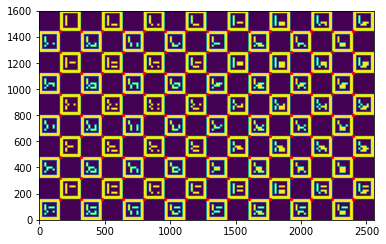

In [167]:
board = ArucoCalibrationBoard(SCREEN_RESOLUTION[0], SCREEN_RESOLUTION[1])
board.to_png(CALIBRATION_IMAGE_DEST)
plt.figure()
plt.imshow(board.image, extent=[0, board.image.shape[1], 0, board.image.shape[0]])
plt.scatter(*board.objp[:, :2].T, color='red', s=5)

### Capture

Now display in fullscreen the image savec above and take pictures of it

**Importante Note**: Make sure your screen is big enough to occupy a decent surface of the image > 33%)

**Importante Note**: Move around while taking pictures. Something like +-40deg on both axis should be good

**Importante Note**: Make sure to take pictures of the grid such that over the course of the dataset you cover thouroughly the entire frame. Ie. sometimes in the center, sometimes in the right corner, sometimes in the left corner. We want to collect data on the entirety of the lens not just the center

### Adjustments

You can now adjust the black and white point using the `CILP_PERCENTILES` to ensure your markers are consistently detected


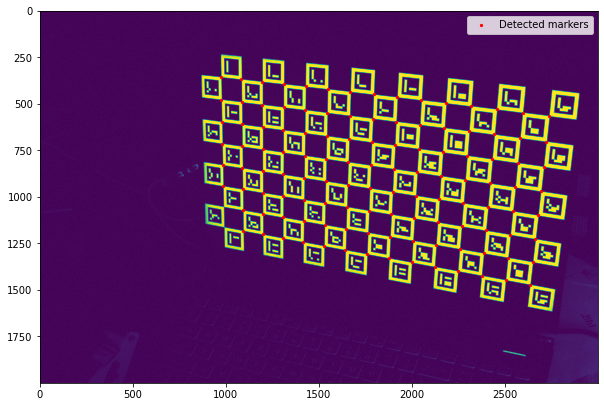

In [147]:
image_filenames = glob(path.join(IMAGE_FOLDER, f'*.{IMAGE_EXTENSION}'))

CLIP_PERCENTILE = [50, 90]

image_index = 0
first_image, _ = imread(image_filenames[image_index])
adjusted_image = prepare_image_for_aruco(first_image, CLIP_PERCENTILE)

# coords, corner_ids, targets = board.detect(adjusted_image, pixel_size_mm=PIXEL_DIMENSION_MM)

fig = plt.figure()
fig.set_size_inches(10, 10)
# plt.scatter(*coords.T, color='red', s=5, label='Detected markers')
plt.legend()
plt.imshow(adjusted_image)

In [148]:
lens, reprojection_errors = Lens.calibrate_from_measurements(
    image_filenames, board,
    PIXEL_DIMENSION_MM, CLIP_PERCENTILE)

loading and analyzing images:   0%|          | 0/29 [00:00<?, ?it/s]

Fitting parameters: 0it [00:00, ?it/s]

### Result

Below are the results for the calibration. The unit for the loss is in pixel, so the larger your image sensor the larger it will be. However with a relatively good lens and camera it is relatively reasoanble to try to aim at an below 1 pixel on average.

This is especially true if shooting RAW where we by default divide the resolution by 2 when loading them from disc.

For reference the results below were obtained with a Canon R6mk2 with a cheap EF 50mm F1.8 lens opened at F5.6.

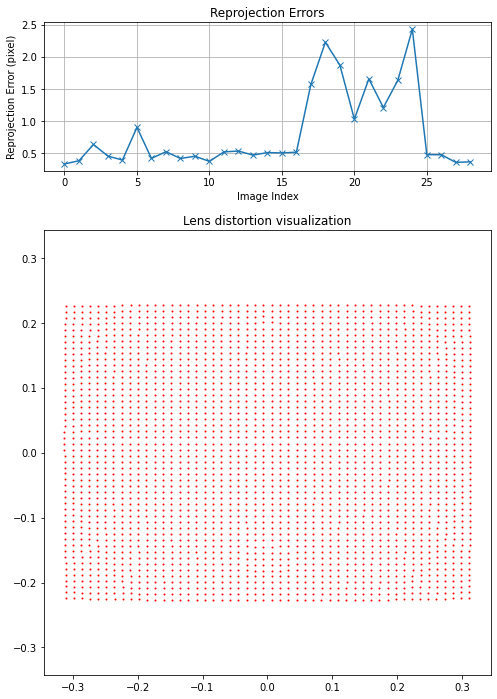

In [149]:
projected_points = visualize_lens_distortion(lens.intrinsic, lens.distortions)
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
ax1 = fig.add_subplot(gs[0])
ax1.plot(reprojection_errors, '-x')
ax1.grid()
ax1.set_title('Reprojection Errors')
ax1.set_ylabel('Reprojection Error (pixel)')
ax1.set_xlabel('Image Index')

ax2 = fig.add_subplot(gs[1])
ax2.scatter(*projected_points.T, s=1, color='red')
ax2.set_title('Lens distortion visualization')
ax2.axis('equal')
None

### Writing calibration file

If you are satisfied with the results you can now write your calibration file to disc

In [150]:
lens.to_disk('/data/keoscope/calibration_R6mk2/50mm-f1.8-focus-close.json')